# Jupyter notebook illustrating the use of PmagPy for analysis of paleomagnetic data


This notebook accompanies a manuscript submitted to the journal EARTH AND SPACE SCIENCE entitled: 

**PmagPy: Software package for paleomagnetic data analysis and a bridge to the Magnetics Information Consortium (MagIC) Database**

*L. Tauxe, R. Shaar, L. Jonestrask, N.L. Swanson-Hysell, K. Gaastra, L. Fairchild, N. Jarboe, R. Minnett, A.A.P. Koppers, and C.G. Constable*

#  Before you begin

You may be viewing this notebook as rendered html webpage in which case you can go ahead and simply have a look at it. However, if you wish to execute the code within a downloaded version of this notebook, it is necessary to have an installed distribution of Python and to have downloaded the PmagPy software distribution. The instructions in the PmagPy Cookbook can help get you started:

http://earthref.org/PmagPy/cookbook

The user would also benefit from perusing the 'Survival computer skills' and 'Introduction to Python Programming' chapters of the cookbook if they are new to programming in Python.

#  Introduction

The analysis in this notebook uses data from two contributions within the MagIC database:

Halls, H. (1974), A paleomagnetic reversal in the Osler Volcanic Group, 
northern Lake Superior, Can. J. Earth Sci., 11, 1200–1207, 
doi:10.1139/e74-113. Link to MagIC contribution:
        http://earthref.org/MAGIC/doi/10.1139/e74-113
            
and

Swanson-Hysell, N. L., A. A. Vaughan, M. R. Mustain, and K. E. Asp (2014), Confirmation of progressive plate motion during the Midcontinent Rift’s early magmatic stage from the Osler Volcanic Group, Ontario, Canada, Geochem. Geophys. Geosyst., 15, 2039–2047, doi:10.1002/2013GC005180. Link to MagIC contribution:
http://earthref.org/MAGIC/doi/10.1002/2013GC005180

To explore the use of Jupyter notebooks, follow each of these links and click on the text file icon in the Data column.  Move each of the files from your download directory into a 'Project Directory' on your hard drive.  In the example below, the project directory for the Halls data set is **Halls1974** and for the Swanson-Hysell data set, **Swanson-Hysell2014** within a subdirectory with the notebook code in it.  Fire up a command line prompt (cmd on PCs and `terminal' in the Applications/Utilities folder on a Mac) and type ```jupyter notebook``` or ```ipython notebook``` to launch a notebook environment within your default web browser.  

In this notebook, we will us PmagPy to:

* Unpack data downloaded from the MagIC database.
* Plot directions and VGPs.
* Calculate and plot Fisher means for directions and VGPs.
* Conduct a bootstrap fold test on the data.
* Conduct a common mean test between the data from the two contributions.

# Import necessary function libraries for data analysis

The code block below imports necessary modules from PmagPy that provide functions that will be used in the data analysis. Using 'sys.path.insert' allows you to point to the directory where you keep PmagPy in order to import it. **You will need to change the path (in the form of '/Users/YOUR_NAME/PmagPy') to match where the PmagPy folder is on your computer.**  Note that text after the pound sign is a comment and will be ignored.  To execute the code, click on play button in the menu bar, choose run under the 'cell' menu at the top of the notebook, or type shift+enter.

With the PmagPy folder in your PYTHONPATH, the function modules from **PmagPy** can be imported:  **pmag**, a module with ~160 (and growing) functions for analyzing paleomagnetic and rock magnetic data.  **ipmag**, a module with functions that combine and extend **pmag** functions and generate output that works well within the Jupyter notebook environment, and **ipmagplotlib**, a module with functions that make various plots used in paleomagnetic data visualization. 

In [3]:
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.pmag as pmag

There are three other important Python libraries (which are bundled with the Canopy and Anaconda installations of Python) that come in quite handy and are used within this notebook:  **numpy** for data analysis using arrays, **pandas** for data manipulation within dataframes and **matplotlib** for plotting. The call ```%matplotlib inline``` results in the plots being shown within this notebook rather than coming up in external windows. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Background on the Osler Volcanic Group

The data being analyzed in this notebook come from lava flows of the Osler Volcanic Group which is a sequence of Midcontinent Rift lava flows exposed on Black Bay Peninsula and the Lake Superior Archipelago in northern Lake Superior. Halls (1974; doi:10.1139/e74-113) conducted the first paleomagnetic study of these flows and determined that they were of dominantly reversed polarity with a paleomagnetic reversal very near to the top of the exposed stratigraphy. This reversal is associated with the deposition of a conglomerate unit and an angular unconformity. The data presented in Halls (1974) from the reversed polarity lavas were from flows high in the succession in close stratigraphic proximity to a sequence of felsic flows at Agate Point---one of which was dated by Davis and Green (1997; doi:10.1139/e17-039) with a resulting $^{207}$Pb/$^{206}$Pb date on zircon of 1105.3 ± 2.1 Ma. Swanson-Hysell et al. (2014; doi:10.1002/2013GC005180) conducted a paleomagnetic study that spanned more of the Osler Group flows from their base up to the upper portions of the exposed reversed polarity flows. The analysis of these data determined that there was a significant change in direction between the data from flows in the lower third of the reversed polarity stratigraphy and those in the upper third stratigraphy. This change was interpretted to be caused by a progression along the apparent polar wander path associated with equatorward motion of Laurentia.

# Import data into the notebook

## Unpack files downloaded from the MagIC database

Data within the MagIC database can be downloaded as a single .txt file. This file can be split into its constituent Earthref and pmag tables either within the QuickMagic GUI, using a command line PmagPy program or using the function **ipmag.download_magic** within the notebook as is done here. The code block below uses this function by giving the file name, specifying where it is and telling it where to unpack the data set into the magic tables. Once these tables are unpacked, we can use them for subsequent data analysis. The ```%%capture``` line blocks annoying messages printed by the **ipmag.download_magic** function.  

In [5]:
%%capture
ipmag.download_magic('zmab0089123tmp02.txt',
                     dir_path='./Halls1974',
                     input_dir_path='./Halls1974',
                     overwrite=True,print_progress=False)
ipmag.download_magic('magic_contribution_10231.txt',
                     dir_path='./Swanson-Hysell2014',
                     input_dir_path='./Swanson-Hysell2014',
                     overwrite=True,print_progress=False)

True

## Loading the unpacked data into Pandas Dataframes

With the results unpacked from MagIC, the data can now be analyzed within the notebook. The data from the Halls1974/pmag_sites.txt table can be imported in order to look at the directions from each site. A nice way to deal with data within Python is using the dataframe structure of the pandas package. The code block below uses the pd.read_csv function to create a dataframe from the pmag_sites.txt file. All MagIC formatted files are tab delimited (sep='\t') with two header lines, one with the type of delimiter and MagIC table and one with the MagIC database column names. To see the formats for MagIC tables, go to http://earthref.org/MAGIC/metadata.htm.
To skip the first header line in a particular file, set skiprows=1.  The ```data_frame_name.head(X)``` function allows us to inspect the first ```X``` rows of the dataframe (in this case 4).

In [6]:
Halls1974_sites = pd.read_csv('./Halls1974/pmag_sites.txt',sep='\t',skiprows=1)
Halls1974_sites.head(4)

,er_citation_names,er_location_name,er_site_name,magic_method_codes,site_dec,site_inc,site_k,site_n,site_polarity,site_tilt_correction
0,This study,"Osler Volcanics, Nipigon Strait, Upper Normal",1,DE-K:FS-FD:FS-H:LP-DC2:SO-SM,289.8,43.6,517,5,n,100
1,This study,"Osler Volcanics, Nipigon Strait, Upper Normal",1,DE-K:FS-FD:FS-H:LP-DC2:SO-SM,293.1,34.5,517,5,n,0
2,This study,"Osler Volcanics, Nipigon Strait, Upper Normal",2,DE-K:FS-FD:FS-H:LP-DC2:SO-SM,285.7,42.0,243,5,n,100
3,This study,"Osler Volcanics, Nipigon Strait, Upper Normal",2,DE-K:FS-FD:FS-H:LP-DC2:SO-SM,290.6,31.9,243,5,n,0


## Filtering by polarity and tilt-correction

Let's start our analysis on the reversed polarity sites that are below an angular unconformity in the Halls (1974) data set. A nice thing about dataframes is that there is built-in functionality to filter them based on column values. The code block below creates a new dataframe of sites that have the site_polarity value of 'r' in the pmag_sites table. It then creates one dataframe for tilt-corrected sites (value of 100 in site_tilt_correction) and sites that have not been tilt-corrected (value of 0 in site_tilt_correction).

In [7]:
Halls1974_sites_r = Halls1974_sites.ix[Halls1974_sites.site_polarity=='r']
Halls1974_sites_r_tc = Halls1974_sites_r.ix[Halls1974_sites_r.site_tilt_correction==100]
Halls1974_sites_r_tc.reset_index(inplace=True)
Halls1974_sites_r_is = Halls1974_sites_r.ix[Halls1974_sites_r.site_tilt_correction==0]
Halls1974_sites_r_is.reset_index(inplace=True)

# Data analysis and visualization

The data can be analyzed and visualized using PmagPy functions. We will first create a directory called 'Notebook_Output'  from within the notebook (using the initial ! before the command invokes a command as if typed on the command line from within a notebook) so that we have a place to put saved figures.  You can do this outside of the notebook if you prefer.   

In [8]:
!mkdir 'Notebook_Output'

mkdir: Notebook_Output: File exists


## Calculating Fisher means

Fisher means for the data can be calculated with the function **ipmag.fisher_mean**. This function takes in a list of declination values, a list of inclination values and returns a dictionary that gives the Fisher mean and associated statistical parameters. This dictionary is printed out for the mean of the tilt-corrected data within the first code block. The second code block uses the **ipmag.print_direction_mean** to print out a formatted version of these same results.

In [9]:
Halls1974_r_is_mean = ipmag.fisher_mean(Halls1974_sites_r_is.site_dec.tolist(),
                                        Halls1974_sites_r_is.site_inc.tolist())
Halls1974_r_tc_mean = ipmag.fisher_mean(Halls1974_sites_r_tc.site_dec.tolist(),
                                        Halls1974_sites_r_tc.site_inc.tolist())
print Halls1974_r_tc_mean

{'csd': 12.780983354077163, 'k': 40.164419949836713, 'n': 25, 'r': 24.402456203028084, 'alpha95': 4.6244793676899487, 'dec': 114.96744501761694, 'inc': -57.572956213862817}


In [10]:
print 'The mean for the tilt-corrected Halls (1974) Osler directions is:'
ipmag.print_direction_mean(Halls1974_r_tc_mean)

The mean for the tilt-corrected Halls (1974) Osler directions is:
Dec: 115.0  Inc: -57.6
Number of directions in mean (n): 25
Angular radius of 95% confidence (a_95): 4.6
Precision parameter (k) estimate: 40.2


## Plotting the Halls (1974) results

The code block below creates a figure with an equal area stereonet and uses the **ipmag.plot_di** function to plot the data both in tilt-corrected and *in situ* coordinates.

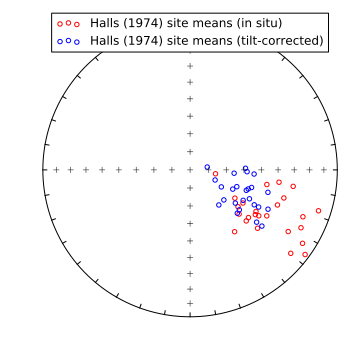

In [11]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(fignum=1)
ipmag.plot_di(Halls1974_sites_r_is.site_dec.tolist(),
              Halls1974_sites_r_is.site_inc.tolist(),'r',
              label='Halls (1974) site means (in situ)')
ipmag.plot_di(Halls1974_sites_r_tc.site_dec.tolist(),
              Halls1974_sites_r_tc.site_inc.tolist(),'b',
             label='Halls (1974) site means (tilt-corrected)')
plt.legend(loc=9)
plt.savefig('Notebook_Output/Halls_1974_sites.svg')

A similar plot showing the Fisher means of the site means calculated above and their associated $\alpha_{95}$ confidence ellipses can be generated using the **ipmag.plot_di_mean** function. Both of these figures can be saved out of the notebook using the ```plt.savefig()``` function. The saved figure file type can be .png, .eps, .svg among others. Saved figures can be used as is for publication or, if necessary, exported vector graphics (e.g. .eps and .svg files) can be editted with software such as Adobe Illustrator or Inkscape.  

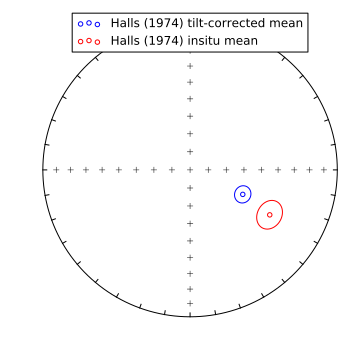

In [12]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(fignum=1)
ipmag.plot_di_mean(Halls1974_r_tc_mean['dec'],
                   Halls1974_r_tc_mean['inc'],
                   Halls1974_r_tc_mean['alpha95'],'b',
                   label='Halls (1974) tilt-corrected mean')
ipmag.plot_di_mean(Halls1974_r_is_mean['dec'],
                   Halls1974_r_is_mean['inc'],
                   Halls1974_r_is_mean['alpha95'],'r',
                   label='Halls (1974) insitu mean')
plt.legend(loc=9)
plt.savefig('Notebook_Output/Halls_1974_means.svg')

The means that have been calculated are now dictionaries that can be made into a new dataframe to present the results. A table like this can be exported into a variety of formats (e.g. LaTEX, html, csv) for inclusion in a publication.

In [13]:
Halls1974_r_is_mean = ipmag.fisher_mean(Halls1974_sites_r_is.site_dec.tolist(),
                                        Halls1974_sites_r_is.site_inc.tolist())
Halls1974_r_tc_mean = ipmag.fisher_mean(Halls1974_sites_r_tc.site_dec.tolist(),
                                        Halls1974_sites_r_tc.site_inc.tolist())
means = pd.DataFrame([Halls1974_r_is_mean,Halls1974_r_tc_mean],
                     index=['Halls 1974 Osler R (insitu)','Halls 1974 Osler R (tilt-corrected)'])
means

,alpha95,csd,dec,inc,k,n,r
Halls 1974 Osler R (insitu),7.429483,20.147915,119.491601,-37.834483,16.162548,25,23.515086
Halls 1974 Osler R (tilt-corrected),4.624479,12.780983,114.967445,-57.572956,40.164420,25,24.402456


Alternatively, one can export the MagIC data table pmag_results.txt into a tab delimited or latex file using the PmagPy program: **pmag_results_extract.py** which can be run at the command line as:
```
pmag_results_extract.py -f Halls1974/pmag_results.txt
```
```
pmag_results_extract.py -f Halls1974/pmag_results.txt -tex
```
or executed as shell command within the notebook by using the ! prefix as is done in the cell block below.

In [14]:
!pmag_results_extract.py -f Halls1974/pmag_results.txt

data saved in:  /Users/Laurentia/0000_Github/2016_Tauxe-et-al_PmagPy_Notebooks/Directions.txt /Users/Laurentia/0000_Github/2016_Tauxe-et-al_PmagPy_Notebooks/Intensities.txt /Users/Laurentia/0000_Github/2016_Tauxe-et-al_PmagPy_Notebooks/SiteNfo.txt


## Combining and plotting the Halls (1974) and Swanson-Hysell et al. (2014) data

First, let's read in the data from the pmag_results.txt table into a Pandas dataframe.

In [15]:
SH2014_sites = pd.read_csv('./Swanson-Hysell2014/pmag_results.txt',sep='\t',skiprows=1)
SH2014_sites.head(1)

,average_age,average_age_high,average_age_low,average_age_unit,average_alpha95,average_dec,average_height,average_inc,average_lat,average_lon,...,er_site_names,magic_method_codes,pmag_result_name,tilt_dec_corr,tilt_dec_uncorr,tilt_inc_corr,tilt_inc_uncorr,vgp_alpha95,vgp_lat,vgp_lon
0,1106,1110,1103,Ma,2.7,79.7,11.8,-70.5,48.8122,-87.662,...,SI1(11.8 to 26.4),DE-FM:LP-DC4:LP-DIR-AF,SI1(11.8 to 26.4),79.7,120.3,-70.5,-77.1,NaN,33.1,229.6


Swanson-Hysell et al. (2014) argued that data from the upper third of the Simpson Island stratigraphy should be compared with the reverse data from the Halls (1974) Nipigon Strait region study. The dataframe can be filtered using the average_height value from the pmag_results table.

In [16]:
SH2014_OslerR_upper = SH2014_sites.ix[SH2014_sites.average_height>2082]
SH2014_OslerR_upper.reset_index(inplace=True)
SH2014_OslerR_upper.head()

,index,average_age,average_age_high,average_age_low,average_age_unit,average_alpha95,average_dec,average_height,average_inc,average_lat,...,er_site_names,magic_method_codes,pmag_result_name,tilt_dec_corr,tilt_dec_uncorr,tilt_inc_corr,tilt_inc_uncorr,vgp_alpha95,vgp_lat,vgp_lon
0,50,1106,1110,1103,Ma,4.3,120.7,2089.0,-56.8,48.7499,...,SI4(106.0 to 121.4),DE-FM:LP-DC4:LP-DIR-AF,SI4(106.0 to 121.4),120.7,140.0,-56.8,-46.6,NaN,46.4,190.3
1,51,1106,1110,1103,Ma,4.1,111.5,2104.4,-50.9,48.7494,...,SI4(121.4 to 127.3),DE-FM:LP-DC4:LP-DIR-AF,SI4(121.4 to 127.3),111.5,129.6,-50.9,-43.6,NaN,36.9,190.4
2,52,1106,1110,1103,Ma,4.7,109.6,2116.8,-60.6,48.7490,...,SI4(133.8 to 143.1),DE-FM:LP-DC4:LP-DIR-AF,SI4(133.8 to 143.1),109.6,134.8,-60.6,-52.7,NaN,41.7,201.8
3,53,1106,1110,1103,Ma,4.0,151.1,2143.4,-62.4,48.7485,...,SI4(160.4 to 171.1),DE-FM:LP-DC4:LP-DIR-AF,SI4(160.4 to 171.1),151.1,163.7,-62.4,-46.6,NaN,69.5,179.1
4,54,1106,1110,1103,Ma,2.2,126.1,2336.0,-68.9,48.7466,...,SI8(0.0 to 3.9),DE-FM:LP-DC4:LP-DIR-AF,SI8(0.0 to 3.9),126.1,152.4,-68.9,-56.4,NaN,56.4,209.4


Let's fish out the declinations and inclinations in geographic (*in situ*) coordinates (is) and those in tilt-corrected coordinates (tc) from the pmag_results table from the Swanson-Hysell2014 dataset and convert them from a dataframe object to a python list object.  We can see what happened with a print command. 

In [17]:
SH2014_upperR_dec_is = SH2014_OslerR_upper['tilt_dec_uncorr'].tolist()
SH2014_upperR_inc_is = SH2014_OslerR_upper['tilt_inc_uncorr'].tolist()
SH2014_upperR_dec_tc = SH2014_OslerR_upper['tilt_dec_corr'].tolist()
SH2014_upperR_inc_tc = SH2014_OslerR_upper['tilt_inc_corr'].tolist()
print SH2014_upperR_inc_tc

[-56.799999999999997, -50.899999999999999, -60.600000000000001, -62.399999999999999, -68.900000000000006, -71.599999999999994, -59.100000000000001, -64.400000000000006, -69.599999999999994, -66.0, -65.200000000000003, -63.299999999999997, -63.0, -65.299999999999997, -72.200000000000003, -78.599999999999994, -79.5, -53.299999999999997, -52.0, -55.299999999999997, -66.299999999999997, -61.0, -48.399999999999999, -53.600000000000001, -55.600000000000001, -57.100000000000001, -42.5, -50.399999999999999, -49.399999999999999, -56.0, -60.899999999999999, -61.0, -70.0, -52.5]


And now the same for the Halls1974 data table.

In [18]:
Halls1974_upperR_dec_is = Halls1974_sites_r_is['site_dec'].tolist()
Halls1974_upperR_inc_is = Halls1974_sites_r_is['site_inc'].tolist()
Halls1974_upperR_dec_tc = Halls1974_sites_r_tc['site_dec'].tolist()
Halls1974_upperR_inc_tc = Halls1974_sites_r_tc['site_inc'].tolist()

We can combine the data from the two papers using the **numpy** (np) concatenate function:

In [19]:
combined_upperR_dec_is = np.concatenate((SH2014_upperR_dec_is,
                                        Halls1974_upperR_dec_is), axis=0)
combined_upperR_inc_is = np.concatenate((SH2014_upperR_inc_is,
                                        Halls1974_upperR_inc_is), axis=0)

combined_upperR_dec_tc = np.concatenate((SH2014_upperR_dec_tc,
                                        Halls1974_upperR_dec_tc), axis=0)
combined_upperR_inc_tc = np.concatenate((SH2014_upperR_inc_tc,
                                        Halls1974_upperR_inc_tc), axis=0)

Now we can plot the data!

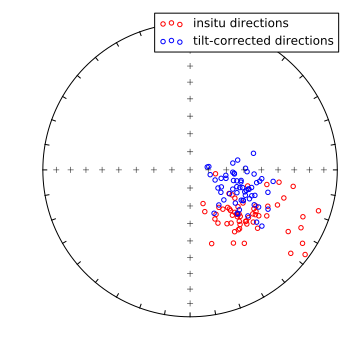

In [20]:
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(fignum=1)
ipmag.plot_di(combined_upperR_dec_is,
              combined_upperR_inc_is,'r', label='insitu directions')
ipmag.plot_di(combined_upperR_dec_tc,
              combined_upperR_inc_tc,'b', label='tilt-corrected directions')
plt.legend()
plt.show()

And print out some useful summary information. 

In [21]:
OslerUpper_is_mean = ipmag.fisher_mean(combined_upperR_dec_is,
                                       combined_upperR_inc_is)
print "The Fisher mean of the insitu upper Osler R directions:"
ipmag.print_direction_mean(OslerUpper_is_mean)
print ''
OslerUpper_tc_mean = ipmag.fisher_mean(combined_upperR_dec_tc,
                                      combined_upperR_inc_tc)
print "The Fisher mean of the tilt-corrected upper Osler R directions:"
ipmag.print_direction_mean(OslerUpper_tc_mean)
print ''
print 'The k_2/k_1 ratio is:'
print OslerUpper_tc_mean['k']/OslerUpper_is_mean['k']

The Fisher mean of the insitu upper Osler R directions:
Dec: 128.3  Inc: -47.6
Number of directions in mean (n): 59
Angular radius of 95% confidence (a_95): 4.2
Precision parameter (k) estimate: 19.9

The Fisher mean of the tilt-corrected upper Osler R directions:
Dec: 110.9  Inc: -59.9
Number of directions in mean (n): 59
Angular radius of 95% confidence (a_95): 2.8
Precision parameter (k) estimate: 43.9

The k_2/k_1 ratio is:
2.20159915009


## Fold test on the site mean directions

In the above plot, the blue directions that have been corrected for tilting have a higher precision than the red values that are uncorrected for tilting. The ratio of the precision parameter from before and after tilt-correction ($k_2$/$k_1$) is 2.2 (see output of code above). Calculating this ratio provides a way to qualitatively assess whether there is improvement in the precision of the data such that the magnetization was likely acquired prior to tilting. This ratio was at the heart of the McElhinny (1964; doi:10.1111/j.1365-246X.1964.tb06300.x) fold test (in which this would constitute of a positive test). However, that test has been shown to not be meaningful as summarized by McFadden (1990; doi:10.1111/j.1365-246X.1990.tb01761.x).    

Halls (1974) noted that the precision increases with structural correction in the Osler dataset, but did not report the values of a statistical fold test. Swanson-Hysell et al. (2014) included all of these data, but did not report the results of the fold test. Here we conduct a Tauxe and Watson (1994; doi:10.1016/0012-821X(94)90006-X) bootstrap fold test on these data that reveals that the tightest grouping of vectors is acheived upon correction for bedding tilt thereby constituting a positive fold test.

Before we can do that, we must wrangle the data into the format expected by the foldtest program.  We can start with the in situ directions from the pmag_results.txt files and pair them with the bedding  orientations in the er_sites.txt files for each of the studies.  

The *in situ* (geographic coordinates) for the reverse sites from  Halls (1974) were read in from the pmag_sites table into Halls1974_sites_r_is.   We read the data from the Swanson-Hysell 2014 data from pmag_results table, so the column headers are different.  Both of these data sets must be paired with the bedding information in the er_sites tables for each study and put into the format expected by the function **ipmag.bootstrap_fold_test** which expects an array of declination, inclination, dip direction and dip for all the sites where the directional data are in geographic coordinations.   

The first step is to make a container for the directions and orientations.  In this case, we make an empty list OslerR_upper_diddd.

In [22]:
OslerR_upper_diddd=[]

Let's start with the Halls (1974) data set in Halls1974_sites_r_is. It is handier for the MagIC data tables in this exercise to have a list of dictionaries instead of a Pandas data frame.  So let's convert the Halls 1974 filtered dataframe to a list of dictionaries called Halls1974.  

In [23]:
Halls1974=Halls1974_sites_r_is.T.to_dict().values()

Now we can read in the data from the er_sites.txt table (with the bedding attitudes) using the function **pmag.magic_read** which reads in magic tables into a list of dictionaries.  Then we will step through the records and pair each site with its bedding orientations using a handy function **get_dict_item** from the  **pmag** library that will find correct site record. The function expects a list of dictionaries (Halls1974_sites), a key to filter on ('er_site_name'), the value of the key (**pmag.magic_read** reads things in as strings but because the names are numbers, pandas converted them to integers, hence the str(site['er_site_name']), and whether the two must be equal ('T'), not equal ('F'), contain ('has') or not contain ('not').   After finding the correct orientation record for the site, we can put the directions and bedding orientations together into the list **OslerR_upper_diddd**.  

In [24]:
Halls1974_sites,filetype=pmag.magic_read('Halls1974/er_sites.txt') # reads in the data
for site in Halls1974:
    orientations=pmag.get_dictitem(Halls1974_sites,'er_site_name',
                                       str(site['er_site_name']),'T')
    if len(orientations)>0: # record found
        OslerR_upper_diddd.append([site['site_dec'],site['site_inc'], 
                        float(orientations[0]['site_bed_dip_direction']),
                                   float(orientations[0]['site_bed_dip'])])
    else:
        print 'no orientations found for site, ',site['er_site_name']

We can do the same for the filtered upper Osler sequence of Swanson-Hysell et al. (2014).  These have slightly different keys, but the general idea is the same.  In the cell below we convert the dataframe to a list of dictionaries, fish out the bedding orientations and attach them to the same list as before (OslerR_upper_diddd).  

In [25]:
SH2014=SH2014_OslerR_upper.T.to_dict().values()
SH2014_sites,filetype=pmag.magic_read('Swanson-Hysell2014/er_sites.txt')
for site in SH2014:
    orientations=pmag.get_dictitem(SH2014_sites,'er_site_name', 
                                   str(site['er_site_names']),'T')
    if len(orientations)>0: # record found
        OslerR_upper_diddd.append([site['tilt_dec_uncorr'],site['tilt_inc_uncorr'], 
                        float(orientations[0]['site_bed_dip_direction']),
                                   float(orientations[0]['site_bed_dip'])])
    else:
        print 'no orientations found for site, ',site['er_site_names']

KeyError: 'site_bed_dip_direction'

Now all we have to do is make a numpy array out of the OslerR_upper_diddd and send it to the **ipmag.bootstrap_fold_test** function. 

doing  100  iterations...please be patient.....


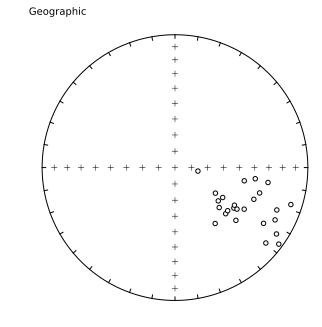

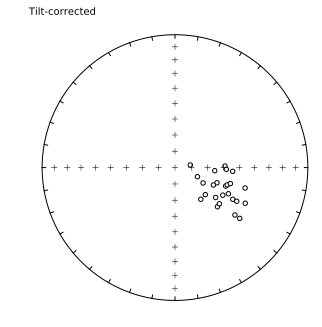


tightest grouping of vectors obtained at (95% confidence bounds):
123 - 139 percent unfolding
range of all bootstrap samples: 
117  -  139 percent unfolding


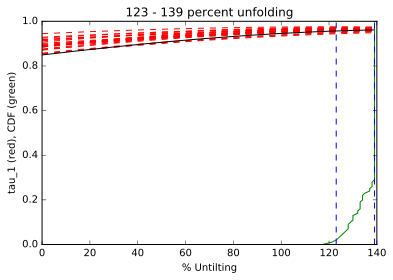

In [26]:
diddd=np.array(OslerR_upper_diddd)
ipmag.bootstrap_fold_test(diddd,num_sims=100, min_untilt=0, max_untilt=140)

# Developing a mean paleomagnetic pole

The virtual geomagnetic poles (VGPs) calculated from the Halls (1974) and Swanson-Hysell (2014) site means can be combined into a single paleomagnetic pole for the upper portion of the reversed polarity Osler Volcanic Group flows. Developing such a combined pole makes sense from a stratigraphic perspective given that the data come from a similar portion of the Osler Volcanic Group stratigraphy. We can test whether or not this combination makes sense from the data themselves by posing the question: are the data sets consistent with being drawn from a common mean? 

First, the VGP longitudes and latitudes for the Halls (1974) data can be accessed from the pmag_results table. The first 5 entries in that table are for the normal polarity sites and the last two are summary poles so they are dropped from the data frame.

In [27]:
Halls1974_results = pd.read_csv('./Halls1974/pmag_results.txt',sep='\t',skiprows=1)
Halls1974_results_r = Halls1974_results.drop([0,1,2,3,4,30,31])
Halls1974_results_r.head(1)

,average_alpha95,average_dec,average_inc,average_k,average_lat,average_lat_sigma,average_lon,average_lon_sigma,average_n,average_r,...,magic_method_codes,pmag_result_name,pole_comp_name,reversal_test,rock_magnetic_test,tilt_correction,vgp_alpha95,vgp_lat,vgp_lon,vgp_n
5,NaN,106.1,-44.2,NaN,48.661051,NaN,271.948459,NaN,1,NaN,...,DE-DI:FS-LOC-GOOGLE:LP-DC2,VGP : Site 6,Characteristic,ND,ND,100,NaN,29.540889,188.653302,1


The data can be made into a list of [vgp_lon, vgp_lat] values using the **ipmag.make_di_block** function.

In [28]:
SH_vgps = ipmag.make_di_block(SH2014_OslerR_upper['vgp_lon'].tolist(),
                              SH2014_OslerR_upper['vgp_lat'].tolist())
Halls_vgps = ipmag.make_di_block(Halls1974_results_r['vgp_lon'].tolist(),
                              Halls1974_results_r['vgp_lat'].tolist())

## Conducting a common mean test 

The question "are the data sets consistent with being drawn from a common mean?" can be addressed utilizing the **ipmag.watson_common_mean** function. This function calculates Watson's V statistic from input data through Monte Carlo simulation in order to test whether two populations of directional data could have been drawn from a common mean. The critical angle between the two sample mean directions and the corresponding McFadden and McElhinny (1990) classification is also printed. A plot can be shown of the cumulative distribution of the Watson V statistic as calculated during the Monte Carlo simulations.

Results of Watson V test: 

Watson's V:           5.4
Critical value of V:  6.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 7.0
Critical angle for M&M1990:   7.4
The McFadden and McElhinny (1990) classification for
this test is: 'B'


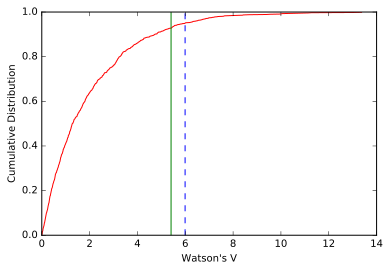

In [29]:
ipmag.watson_common_mean(SH_vgps,Halls_vgps,NumSims=1000,plot='yes')

## Calculating a mean paleomagnetic pole

We can go ahead and calculate a mean paleomagnetic pole combining the VGPs from both studies.

In [30]:
Osler_upperR_pole = pmag.fisher_mean(SH_vgps+Halls_vgps)
ipmag.print_pole_mean(Osler_upperR_pole)

Plong: 201.6  Plat: 42.5
Number of directions in mean (n): 59
Angular radius of 95% confidence (A_95): 3.7
Precision parameter (k) estimate: 25.7


## Plotting VGPs and the mean pole

The code below uses the **ipmag.plot_vgp** function to plot the virtual geomagnetic poles and the **ipmag.plot_pole** function to plot the calculated mean pole along with its $A_{95}$ confidence ellipse.

The plot is developed using the **Basemap** package which enables the plotting of data on a variety of geographic projections. **Basemap** is not a standard part of most scientific python distributions so you may need to take extra steps to install it. If using the Anaconda distribution, you can type ```conda install basemap``` at the command line. The Enthought Canopy distribution has a GUI package manager that you can use for installing the package.

The plot is saved to the Notebook_Output folder as an .svg file.

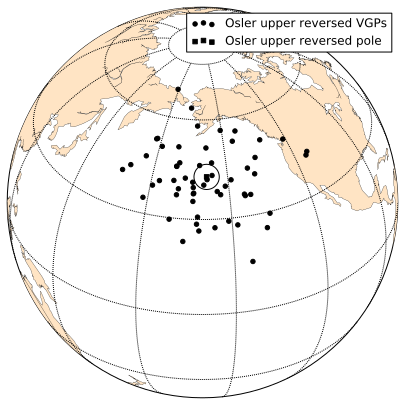

In [31]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='ortho',lat_0=35,lon_0=200,resolution='c',area_thresh=50000)
plt.figure(figsize=(7, 7))
m.drawcoastlines(linewidth=0.25)
m.fillcontinents(color='bisque',zorder=1)
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

ipmag.plot_vgp(m,SH2014_OslerR_upper['vgp_lon'].tolist(),
               SH2014_OslerR_upper['vgp_lat'].tolist(),
               marker='o')

ipmag.plot_vgp(m,Halls1974_results_r['vgp_lon'].tolist(),
               Halls1974_results_r['vgp_lat'].tolist(),
               marker='o',label='Osler upper reversed VGPs')
               
ipmag.plot_pole(m,Osler_upperR_pole['dec'],
             Osler_upperR_pole['inc'],
             Osler_upperR_pole['alpha95'],
             marker='s',label='Osler upper reversed pole')

plt.legend()
plt.savefig('Notebook_Output/pole_plot.svg')
plt.show()

# Concluding thoughts

This notebook is intended to be an illustrative case study of the type of data analysis that can be accomplished using PmagPy within a Jupyter notebook. All the capabilities of PmagPy can be utilized within notebooks, although continued work is needed for the functionality within some of the command line programs to be made into functions that work well within the environment.

An advantage of this type of workflow is that it is well-documented and reproducible. The decisions that went into the data analysis and the implementation of the statistical tests are fully transparent (as is the underlying code). Additionally, if one were to seek to add more data to the mean pole, all of the data analysis could be quickly redone by executing all of the code in the notebook.

Smaller snippets of code that demonstrate additional PmagPy functionality within a notebook can be seen in this notebook which is currently under development: 

https://github.com/PmagPy/2016_Tauxe-et-al_PmagPy_Notebooks/blob/master/Additional_PmagPy_Examples.ipynb


# Works cited

Davis, D., and J. Green (1997), Geochronology of the North American Midcontinent rift in western Lake Superior and implications for its geodynamic evolution, Can. J. Earth Sci., 34, 476–488, doi:10.1139/e17–039.

Halls, H. (1974), A paleomagnetic reversal in the Osler Volcanic Group, northern Lake Superior, Can. J. Earth Sci., 11, 1200–1207, doi:10.1139/e74–113.

McElhinny, M. W. (1964), Statistical Significance of the Fold Test in Palaeomagnetism. Geophysical Journal of the Royal Astronomical Society, 8: 338–340. doi: 10.1111/j.1365-246X.1964.tb06300.x

McFadden, P. L. and McElhinny, M. W. (1990), Classification of the reversal test in palaeomagnetism. Geophysical Journal International, 103: 725–729. doi: 10.1111/j.1365-246X.1990.tb05683.x

McFadden, P. L. (1990), A new fold test for palaeomagnetic studies. Geophysical Journal International, 103: 163–169. doi: 10.1111/j.1365-246X.1990.tb01761.x

Swanson-Hysell, N. L., A. A. Vaughan, M. R. Mustain, and K. E. Asp (2014), Confirmation of progressive plate motion during the Midcontinent Rift’s early magmatic stage from the Osler Volcanic Group, Ontario, Canada, Geochemistry Geophysics Geosystems, 15, 2039–2047, doi:10.1002/2013GC005180.

Tauxe, L., and G. S. Watson (1994), The fold test: an eigen analysis approach, Earth Planet. Sci. Lett., 122, 331–341, doi:10.1016/0012-821X(94)90006-X.